In [119]:
import yfinance as yf
import keras.backend as K
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score, mean_squared_error,mean_absolute_percentage_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential
from keras.optimizer_v2.adam import Adam
from keras.optimizer_v2.rmsprop import RMSprop
import talib

In [120]:
data=yf.download("0700.hk")

[*********************100%***********************]  1 of 1 completed


In [121]:
df = data
data['6day MA'] = data['Close'].rolling(window = 6).mean()
data['12day MA'] = data['Close'].rolling(window = 12).mean()
data['RSI'] = talib.RSI(data['Close'].values, timeperiod = 7)
data['%R5'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 5)
data['%R10'] = talib.WILLR(data['High'].values, data['Low'].values, data['Close'].values, 10)
data['MI6']=talib.MOM(data['Close'],timeperiod=6)
data['MI12']=talib.MOM(data['Close'],timeperiod=12)
macd, macdsignal, macdhist = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['EMA12']=talib.EMA(data['Close'], timeperiod=12)
data['EMA26']=talib.EMA(data['Close'],timeperiod=26)
data['MACD']=macd
data['TR']=talib.TRANGE(data['High'],data['Low'],data['Close'])
data['OSC6']=talib.CMO(data['Close'], timeperiod=6)
data['OSC12']=talib.CMO(data['Close'], timeperiod=12)
df['Prediction'] = data[['Close']].shift(-1)
#print data set
df=df.dropna()
print(df)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2004-08-02    0.770000    0.775000    0.740000    0.775000    0.748967   
2004-08-03    0.780000    0.795000    0.775000    0.790000    0.763463   
2004-08-04    0.780000    0.785000    0.765000    0.770000    0.744134   
2004-08-05    0.780000    0.805000    0.780000    0.795000    0.768295   
2004-08-06    0.785000    0.810000    0.785000    0.800000    0.773127   
...                ...         ...         ...         ...         ...   
2021-12-23  454.000000  468.799988  449.200012  461.799988  461.799988   
2021-12-24  460.799988  460.799988  460.799988  460.799988  460.799988   
2021-12-28  457.799988  459.200012  445.000000  450.399994  450.399994   
2021-12-29  443.600006  445.600006  440.399994  444.799988  444.799988   
2021-12-30  446.399994  450.799988  442.000000  443.399994  443.399994   

              Volume     6day MA    1

In [122]:

# Create a dataset y which will be having Predicted values and convert into numpy array
y = np.array(df['Prediction'])

In [123]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.ensemble import RandomForestRegressor
#k_features=10 (It will get top 10 features best suited for prediction)
#forward=False (Backward feature selection model)
#verbose=2 (It will show details output as shown below.)
#cv=5 (Kfold cross valiation: it will split the training set in 5 set and 4 will be using for training the model and 1 will using as validation)
#n_jobs=-1 (Number of cores it will use for execution.-1 means it will use all the cores of CPU for execution.)
#scoring='r2'(R-squared is a statistical measure of how close the data are to the fitted regression line)
backwardModel=sfs(RandomForestRegressor(),k_features=(1,10),forward=True,verbose=2,cv=0,n_jobs=-1,scoring='r2')
#We will convert our training data into numpy array. If we will not convert it, model is not able to read some of the column names.
backwardModel.fit(np.array(df.drop('Prediction',1)),y.ravel())

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   17.2s finished

[2022-01-01 18:28:01] Features: 5/19 -- score: 0.2043343702021725[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:   10.9s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:   20.2s finished

[2022-01-01 18:28:21] Features: 6/19 -- score: 0.2026287725878449[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  13 | elapsed:   12.2s remaining:   19.5s
[Parallel(n_jobs=-1)]: Done  13 out of  13 | elapsed:   20.4s finished

[2022-01-01 18:28:42] Features: 7/19 -- score: 0.20314080435193343[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    9.2s remaining:   18.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   18.2s finished

[2022-01-01 18:29:00] Features: 8/19 -- score

SequentialFeatureSelector(estimator=RandomForestRegressor(), k_features=(1, 19),
                          n_jobs=-1, scoring='r2', verbose=2)

/var/folders/8h/w0jn89bj2w5g85gj4ck7w0t00000gn/T/ipykernel_82849/938152188.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  backwardModel.fit(np.array(df.drop('Prediction',1)),y.ravel())
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  19 | elapsed:    1.8s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    2.3s finished

[2022-01-01 18:32:23] Features: 1/10 -- score: 0.9997078771512982[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    2.1s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.8s finished

[2022-01-01 18:32:26] Features: 2/10 -- score: 0.9998467455215406[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  17 | elapsed:    2

SequentialFeatureSelector(cv=0, estimator=RandomForestRegressor(),
                          k_features=(1, 10), n_jobs=-1, scoring='r2',
                          verbose=2)

In [150]:
df.columns[list(backwardModel.k_feature_idx_)]

Index(['Open', 'High', 'Close', 'Adj Close', 'RSI', '%R5', 'EMA26', 'MACD',
       'OSC6'],
      dtype='object')

In [125]:
X = df[df.columns[list(backwardModel.k_feature_idx_)]]
x_unseen=X[-100:]
X = X[:-100]
y_unseen=y[-100:]
y = y[:-100]
X.head()

,Open
Date,
2004-08-02,0.770
2004-08-03,0.780
2004-08-04,0.780
2004-08-05,0.780
2004-08-06,0.785


,Open,High,Close,Adj Close,RSI,%R5,EMA26,MACD,OSC6
Date,,,,,,,,,
2004-08-02,0.770,0.775,0.775,0.748967,58.915809,-0.000000,0.784088,-0.028262,24.071279
2004-08-03,0.780,0.795,0.790,0.763463,63.753690,-6.666661,0.784526,-0.023442,34.598565
2004-08-04,0.780,0.785,0.770,0.744134,53.883580,-33.333386,0.783450,-0.020995,10.161008
2004-08-05,0.780,0.805,0.795,0.768295,62.377702,-15.384601,0.784306,-0.016843,29.390628
2004-08-06,0.785,0.810,0.800,0.773127,63.927979,-14.285702,0.785468,-0.013000,32.840655


In [126]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [127]:
regr=make_pipeline(MinMaxScaler(feature_range=(-1,1)),RandomForestRegressor())
regr.fit(x_train,y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler(feature_range=(-1, 1))),
                ('randomforestregressor', RandomForestRegressor())])

Pipeline(steps=[('minmaxscaler', MinMaxScaler(feature_range=(-1, 1))),
                ('randomforestregressor', RandomForestRegressor())])

In [139]:
y_pred=regr.predict(x_test)

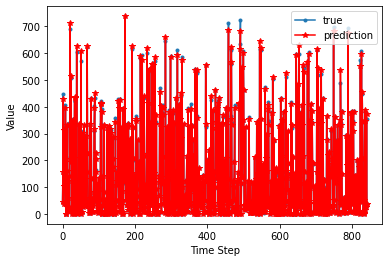

In [140]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [141]:
mean_absolute_percentage_error(y_test,y_pred)

0.020636397948936694

In [142]:
r2_score(y_test,y_pred)

0.9989176384558901

In [143]:
mean_squared_error(y_test,y_pred,squared=False)

5.574434751655233

In [144]:
unseend_pred = regr.predict(x_unseen)

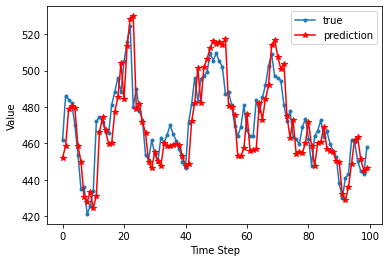

In [145]:
plt.plot(y_unseen, marker='.', label="true")
plt.plot(unseend_pred, 'r',marker='*', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [146]:
mean_absolute_percentage_error(y_unseen,unseend_pred)

0.020901107580042537

In [147]:
r2_score(y_unseen,unseend_pred)

0.6236888940270596

In [148]:
mean_squared_error(y_test,y_pred,squared=False)

5.574434751655233

In [149]:
x_unseen

,Open,High,Close,Adj Close,RSI,%R5,EMA26,MACD,OSC6
Date,,,,,,,,,
2021-08-06,444.799988,460.399994,453.600006,453.600006,37.894738,-45.652156,507.534563,-32.146358,-22.096971
2021-08-09,447.799988,472.399994,461.600006,461.600006,42.430636,-22.131128,504.132003,-30.865059,-11.665801
2021-08-10,478.000000,493.000000,486.200012,486.200012,54.382994,-11.258259,502.803708,-27.547061,15.099159
2021-08-11,490.200012,492.600006,484.000000,484.000000,53.229927,-14.900664,501.410840,-24.809062,12.212738
2021-08-12,482.600006,491.200012,482.000000,482.000000,52.059239,-20.754717,499.973000,-22.540727,9.224644
...,...,...,...,...,...,...,...,...,...
2021-12-23,454.000000,468.799988,461.799988,461.799988,57.863242,-17.587945,460.916855,-8.224775,21.440302
2021-12-24,460.799988,460.799988,460.799988,460.799988,56.801866,-20.100509,460.908198,-6.968748,18.839472
2021-12-28,457.799988,459.200012,450.399994,450.399994,46.461429,-46.700499,460.129812,-6.734894,-6.224634
